# __Imbalance Data class__

목차:

**[I. 데이터 불러오기 및 확인](#one)**

- [a. 데이터 불러오기 및 결측치 확인](#one-a)

**[II. 언더 & 오버 샘플링](#two)**

- [a. RandomOverSampler](#two-a)

**[III. SMOTE](#three)**

- [a. SMOTE-NC](#three-a)
- [b. Borderline-SMOTE](#three-b)
- [c. Borderline-SMOTE SVM](#three-c)

**[IV. ADASYN](#four)**

## 데이터 불러오기 및 확인

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import RFECV

import joblib
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance , plot_tree
import xgboost as xgb
from catboost import CatBoostClassifier
from catboost import Pool

from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, roc_auc_score, accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV,StratifiedKFold,KFold
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

import shap
from sklearn.tree import export_graphviz

import warnings
warnings.filterwarnings(action='ignore')

In [5]:
df = import_db('mart')
df1 = df.copy()
df.head(3)

,store_cd,store_nm,address,x,y,sale_avg,x_y_list,parking_200m,parking_500m,parking_1000m,...,school_yn,mart_yn,starbucks_100,starbucks_500,land_use_intensity,official_land_value,building_counts,sale_grade,sale_grade_ahi,sale_grade_hist
0,10014,개포1호점,서울특별시 강남구 선릉로48 (개포동),127.059738,37.483606,2.975689e+06,"[127.059737727687, 37.4836059941898]",0,1,22,...,1,1,0.0,0.0,120.83,3846887.30,86.0,1,1,1
1,10015,개포2호점,서울특별시 강남구 개포로512(개포동),127.068842,37.489307,5.267541e+06,"[127.068842082027, 37.4893072141263]",3,3,34,...,1,0,0.0,0.0,92.32,6539598.82,26.0,2,4,2
2,10250,소공점,서울시 중구 남대문로7길 11소공동,126.981250,37.563689,3.531775e+07,"[126.981249523015, 37.5636892672995]",20,88,334,...,0,0,1.0,15.0,437.88,38722545.14,39.0,4,5,4


In [6]:
df.drop(['store_cd','store_nm','sale_avg','address','x','y','x_y_list','sale_grade_hist','sale_grade_ahi'], axis=1, inplace=True)

In [7]:
X = df.copy()
y = X.sale_grade
X.drop('sale_grade',axis=1, inplace=True)

In [11]:
model = xgb.XGBClassifier(random_state = 0, eval_metric= 'merror', objective = 'multi:softmax')

# cv default값:  5 folds
# step: 한 회당 삭제할 피쳐 수
selector = RFECV(model, step = 1, cv = 5)
selector = selector.fit(X,y)

print(selector.estimator_)

X_rfecv = X[X.columns[selector.support_].to_list()]
X.columns[selector.support_].to_list()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='merror',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


['parking_500m',
 'parking_1000m',
 'academy_200m',
 'academy_500m',
 'academy_1000m',
 'accommodation_200m',
 'accommodation_500m',
 'bike_count_200m',
 'bike_count_1000m',
 'bike_station_500m',
 'trdar_cd',
 'apt_avg_ae',
 'apt_avg_price',
 'tot_flpop_co',
 'cnsmr_popltn_co',
 'tot_repop_co',
 'total_subpas',
 'sub_500m',
 'con_30m',
 'total_worker',
 'active_pop',
 'cr_in_50m',
 'close_st_dis',
 'st_in_50m',
 'st_in_500m',
 'st_in_1000m',
 'passenger_sum_50m',
 'passenger_sum_500m',
 'trdar_se_r',
 'starbucks_100',
 'land_use_intensity',
 'official_land_value',
 'building_counts']

In [10]:
skf = StratifiedKFold(n_splits=4)
for train_index, test_index  in skf.split(X_rfecv,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
# Train data y값 비율
unique, counts = np.unique(y_train, return_counts=True)
print("Train data set: ", dict(zip(unique, counts)))

# Test data y값 비율
unique, counts = np.unique(y_test, return_counts=True)
print("Test data set: ", dict(zip(unique, counts)))

baseline_model = xgb.XGBClassifier(eval_metric= 'merror', objective = 'multi:softmax',
                         random_state = 0
                         )
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)

# 오차 지표
acc_score = accuracy_score(y_test,y_pred)
# weighted : 각 레이블이 불균형 할 때 가중치 주고 계산함
f1 = f1_score(y_test, y_pred, average = 'weighted', zero_division=1)
print("Accuracy: %.2f%%" % (acc_score * 100))
print("f1_score: %.2f%%" % (f1 * 100))

Train data set:  {1: 35, 2: 15, 3: 4, 4: 2, 5: 1}
Test data set:  {1: 11, 2: 5, 3: 1, 4: 1, 5: 1}


C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 57.89%
f1_score: 55.84%


## 데이터 불균형 처리
- 언더샘플링
    * 다수 클래스가 소수 클래스와 동일한 양의 데이터로 다운 샘플링 되는 것
    * 무작위추출 : 무작위로 정상 데이터 일부만 선택
    * 유의정보 : 유의한 데이터만을 남기는 방식(EasyEnsemble, BalanceCascade)
    * 언더샘플링의 경우 데이터의 소실이 매우 크고, 때로는 중요한 정상데이터를 잃게 될 수 있다.
- 오버샘플링
    * 소수 클래스는 크기가 다수 클래스와 비슷해질 때까지 X번 복사
    * 무작위추출 : 무작위로 소수 데이터 복제
    * 유의정보 : 사전에 기준을 정해서 소수 데이터를 복제
    * 정보가 손실되지 않는다는 장점이 있으나, 복제된 관측치를 원래 데이터 세트에 추가하기 만하면 여러 유형의 관측치를 다수 추가하여 오버 피팅 (overfitting)을 초래
        * trainset의 성능은 높으나 testset의 성능은 나빠질수 있음 
    * 합성 데이터 생성 : 소수 데이터를 단순 복제하는 것이 아니라 새로운 복제본을 만들어 낸다.
    

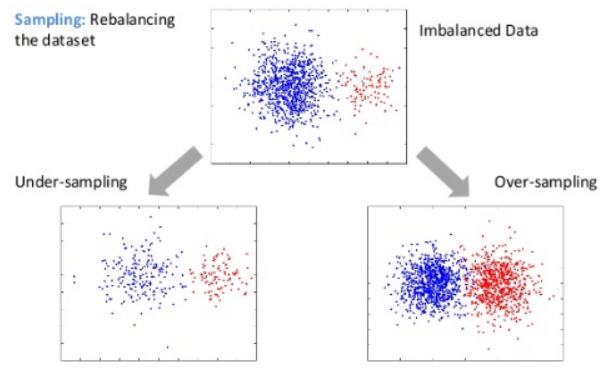

### 오버샘플링

In [117]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

print('Original dataset shape %s' % Counter(y_train))

ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_train_ros))

Original dataset shape Counter({1: 35, 2: 15, 3: 4, 4: 2, 5: 1})
Resampled dataset shape Counter({1: 35, 2: 35, 4: 35, 3: 35, 5: 35})


In [119]:
baseline_model = xgb.XGBClassifier(eval_metric= 'merror', objective = 'multi:softmax',
                         random_state = 0
                         )
baseline_model.fit(X_train_ros, y_train_ros)
y_pred = baseline_model.predict(X_test)

# 오차 지표
acc_score = accuracy_score(y_test,y_pred)

f1 = f1_score(y_test, y_pred, average = 'weighted', zero_division=1)
print("Accuracy: %.2f%%" % (acc_score * 100))
print("f1_score: %.2f%%" % (f1 * 100))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Accuracy: 42.11%
f1_score: 42.11%
[[8 3 0 0 0]
 [3 0 0 2 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 1 0 0 0]]
              precision    recall  f1-score   support

           1       0.73      0.73      0.73        11
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1

    accuracy                           0.42        19
   macro avg       0.15      0.15      0.15        19
weighted avg       0.42      0.42      0.42        19



C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use

In [185]:
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_rfecv, y)

X_train, X_test, y_train, y_test = train_test_split(X_train_ros, y_train_ros, test_size=0.30, shuffle=True, random_state=101)

# Train data y값 비율
unique, counts = np.unique(y_train, return_counts=True)
print("Train data set: ", dict(zip(unique, counts)))

# Test data y값 비율
unique, counts = np.unique(y_test, return_counts=True)
print("Test data set: ", dict(zip(unique, counts)))


baseline_model = xgb.XGBClassifier(eval_metric= 'merror', objective = 'multi:softmax',
                         random_state = 0
                         )
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)

# 오차 지표
acc_score = accuracy_score(y_test,y_pred)
# weighted : 각 레이블이 불균형 할 때 가중치 주고 계산함
f1 = f1_score(y_test, y_pred, average = 'weighted', zero_division=1)
print("Accuracy: %.2f%%" % (acc_score * 100))
print("f1_score: %.2f%%" % (f1 * 100))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Train data set:  {1: 33, 2: 33, 3: 33, 4: 32, 5: 30}
Test data set:  {1: 13, 2: 13, 3: 13, 4: 14, 5: 16}
Accuracy: 91.30%
f1_score: 91.30%
[[10  3  0  0  0]
 [ 3 10  0  0  0]
 [ 0  0 13  0  0]
 [ 0  0  0 14  0]
 [ 0  0  0  0 16]]
              precision    recall  f1-score   support

           1       0.77      0.77      0.77        13
           2       0.77      0.77      0.77        13
           3       1.00      1.00      1.00        13
           4       1.00      1.00      1.00        14
           5       1.00      1.00      1.00        16

    accuracy                           0.91        69
   macro avg       0.91      0.91      0.91        69
weighted avg       0.91      0.91      0.91        69



C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


## SMOTE
- SMOTE
    * 합성 소수 샘플링 기술로 다수 클래스를 샘플링하고 기존 소수 샘플을 보간하여 새로운 소수 인스턴스를 합성함
    * 연속적이고 분류 문제인 데이터를 합성하는 데 사용(합성 데이터가 두 데이터 사이에 무작위로 생성)
    * 1. 소수 클래스에서 각각의 샘플들의 KNN을 찾는다
    * 2. 그 이웃들 사엥서 선을 그어 무작위 점을 생성한다 
        * 소수데이터들 사이를 보간하여 작동하기 때문에 모델링셋의 소수데이터들 사이의 특성만을 반영하고 새로운 사례의 데이터 예측엔 취약할 수 있음
- SMOTE-NC
    * SMOTE 변형으로 범주 및 연속적 기능이 혼합 된 경우 사용 
    * 어떤 기능이 범주 형인지 표시하고 SMOTE는 합성 데이터를 생성하는 대신 범주 형 데이터를 다시 샘플링 
- Borderline-SMOTE 
    * 두 클래스 간의 결정경계를 따라 합성 데이터 만 만듬 
    * 데이터 결정 경계 근처에서 데이터를 합성하려고 시도
- Borderline-SMOTE SVM
    * 클래스 중복 영역에서 더 많은 데이터가 합성됨. 데이터가 분리 된 위치에 더 중점을 둠
    * SVM-SMOTE와 다른 SMOTE의 주요 차이점은 K- 최근 접 이웃을 사용하여 Borderline-SMOTE의 오분류를 식별하는 대신 SVM 알고리즘을 통합
- ADASYN 
    * ADASYN은 데이터 밀도에 따라 합성 데이터를 생성
    * 합성 데이터 생성은 소수 클래스의 밀도에 반비례
    * SMOTE와 동일한 프로세스를 진행한 후 점들에 임의의 작은 값을 더해줌으로써 조금 더 사실적인 데이터가 생성된다


- SMOTE

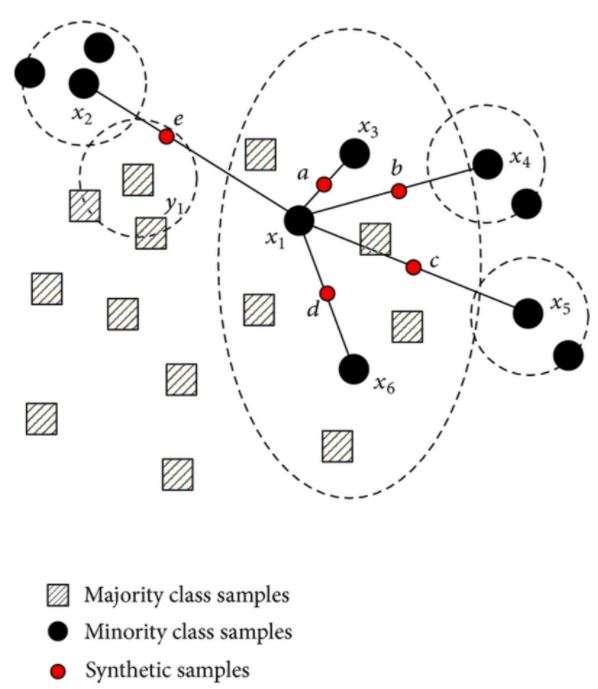

- 에러 : Expected n_neighbors <= n_samples,  but n_samples = 5, n_neighbors = 6
    * a) 데이터가 완벽하게 균형을 이루지 못하고 6 개 미만의 샘플을 가진 클래스가 있고 
    * b) 인접 항목 수가 6 개이기 때문입니다. 
    * 문제에 대한 몇 가지 해결책 : 199 개의 클래스 중 최소 샘플 수 (n_samples)를 계산하고 n_neighborsn_samples 이하인 SMOTE 클래스의 매개 변수를 선택 합니다. class ratio매개 변수를 사용하여 n_samples <n_neighbors로 클래스를 오버 샘플링에서 제외 SMOTE합니다.RandomOverSampler유사한 제한이없는 클래스를 사용하십시오

- 고려사항 
    * SMOTE순서 : RFECV로 선택된 33개의 피처의 데이터셋(X_rfecv) -> ADASYN.fit_resample(X_rfecv,y) -> train_test_split(X_rfecv,y) -> 학습이 맞는지 -> 이거같은데 
    * SMOTE순서2 : RFECV 33개의 피처 -> StratifiedKFold.split(X_rfecv,y) / X_train,y_train -> RandomOverSampler.fit(X_train,y_train) ->  학습이 맞는지 
    
    * 한 class에 대해서 복제를 한거라서 성능이 과적합되지는 않았을까..?

- k_neighbors :  합성 샘플을 구성하는 데 사용되는 가장 가까운 이웃의 수
- n_neighbors : 소수 표본이 위험에 처해 있는지 확인하는 데 사용할 가장 가까운 이웃의 수

In [107]:
from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

In [135]:
smote = SMOTE(k_neighbors=1,random_state=8)
#X_smote,y_smote = smote.fit_resample(X_train, y_train)

- SMOTE의 경우 문제생김! -> Expected n_neighbors <= n_samples,  but n_samples = 5, n_neighbors = 6
    * 데이터 세트의 일부 인스턴스가 너무 적어서 발생
    * 클래스 중 하나에 충분한 샘플이 없기 때문에 오류가 나타납
    * 각 클래스에 최소 6개의 샘플이 필요함, default값

## ADASYN
- ADASYN(*, sampling_strategy='auto', random_state=None, n_neighbors=5, n_jobs=None)
- Adaptive synthetic sampling approach for imbalanced learning
- 합성 데이터를 생성하는 알고리즘으로 동일한 소수 데이터를 복사하지 않고 배우기 어려운 예제에 대해 더 많은 데이터를 생성한다는 것
- 단계
    * 1. 소수 대 다수의 비율을 계산
    * 2. 생성할 합성 소수 데이터의 총 수를 계산
    * 3. 각 소수 예제의 K-최근접 이웃을 찾고 r_i값을 계산, 이 단계 후에 각 소수 사례는 다른 이웃과 연결 
    * 4. 모든 r_i값의 합이 1이 되도록 r_i값을 정규화
    * 5. 이웃당 생성할 합성 사례의 양을 계산 
    * 6. 각 지역에 대한 G_i 데이터를 생성 
- 단점
    * 드물게 분포하는 소수 예의 경우 각 이웃에는 소수 예가 1개만 포함 될 수 있음
        * 소수 예제가 1개만 있는 이웃은 해당 값을 G_i시간으로 복제하거나 이웃에 대한 합성 데이터 생성을 무시하거나 이웃의 크기를 늘림 
    * 적응성 특성(adaptability nature)으로 인해 ADASYN의 Precision이 영향받을 수 있음 
        * 다수의 클래스 예제가 있는 지역에서 더 많은 데이터가 생성되기 때문에 발생, 생성된 합성 데이터가 다수 클래스 데이터와 매우 유사하여 잠재적으로 많은 오탐지를 생성 

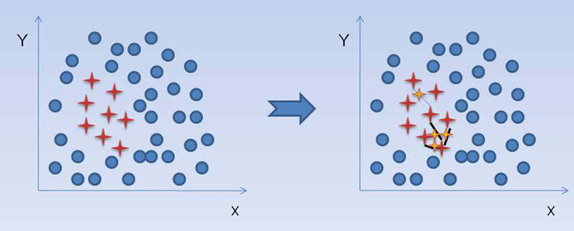

- sampling_strategy : float, str, dict or callable, default=’auto’
    * 'minority': resample only the minority class;
    * 'not minority': resample all classes but the minority class;
    * 'not majority': resample all classes but the majority class;
    * 'all': resample all classes;
    * 'auto': equivalent to 'not majority'.

- random_state : int, RandomState instance, default=None
    * Control the randomization of the algorithm.

- n_neighbors : int or estimator object, default=5
    * 합성 샘플을 구성하는데 사용되는 최근접 이웃 수 

- n_jobsint, default=None
    * Number of CPU cores used during the cross-validation loop

- SMOTE의 에러 해결방법
    *     => ADASYN(sampling_strategy='minority', random_state=8, n_neighbors=1, n_jobs=1) 처럼 n_neighbors와 n_jobs를 임의로 지정해줬는데

## sampling_strategy='minority

In [174]:
print('Original dataset shape %s' % Counter(y_train))

adasyn = ADASYN(sampling_strategy='minority', random_state=8, n_neighbors=1, n_jobs=1)

X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_train_adasyn))

X_train, X_test, y_train, y_test = train_test_split(X_train_adasyn, y_train_adasyn, test_size=0.30, shuffle=True, random_state=101)

baseline_model = xgb.XGBClassifier(eval_metric= 'merror', objective = 'multi:softmax',
                         random_state = 0
                         )
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)

# 오차 지표
acc_score = accuracy_score(y_test,y_pred)
# weighted : 각 레이블이 불균형 할 때 가중치 주고 계산함
f1 = f1_score(y_test, y_pred, average = 'weighted', zero_division=1)
print("Accuracy: %.2f%%" % (acc_score * 100))
print("f1_score: %.2f%%" % (f1 * 100))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Original dataset shape Counter({1: 33, 5: 33, 2: 14, 3: 3, 4: 1})
Resampled dataset shape Counter({1: 46, 5: 46, 2: 20, 3: 5, 4: 3})
Accuracy: 75.00%
f1_score: 72.82%
[[11  2  0  0  0]
 [ 3  3  0  0  0]
 [ 1  1  0  0  0]
 [ 0  0  2  0  0]
 [ 0  0  0  0 13]]
              precision    recall  f1-score   support

           1       0.73      0.85      0.79        13
           2       0.50      0.50      0.50         6
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       1.00      1.00      1.00        13

    accuracy                           0.75        36
   macro avg       0.45      0.47      0.46        36
weighted avg       0.71      0.75      0.73        36



C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use

In [141]:
print('Original dataset shape %s' % Counter(y_train))

ada = ADASYN(sampling_strategy='minority', random_state=8, n_neighbors=1, n_jobs=1)
    
X_res, y_res = ada.fit_resample(X_rfecv, y)

print('Resampled dataset shape %s' % Counter(y_train_adasyn))


Original dataset shape Counter({1: 35, 2: 15, 3: 4, 4: 2, 5: 1})
Resampled dataset shape Counter({1: 46, 5: 46, 2: 20, 3: 5, 4: 3})


In [175]:
skf = StratifiedKFold(n_splits=4)
for train_index, test_index  in skf.split(X_rfecv,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
# Train data y값 비율
unique, counts = np.unique(y_train, return_counts=True)
print("Train data set: ", dict(zip(unique, counts)))

# Test data y값 비율
unique, counts = np.unique(y_test, return_counts=True)
print("Test data set: ", dict(zip(unique, counts)))

baseline_model = xgb.XGBClassifier(eval_metric= 'merror', objective = 'multi:softmax',
                         random_state = 0
                         )
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)

# 오차 지표
acc_score = accuracy_score(y_test,y_pred)
# weighted : 각 레이블이 불균형 할 때 가중치 주고 계산함
f1 = f1_score(y_test, y_pred, average = 'weighted', zero_division=1)
print("Accuracy: %.2f%%" % (acc_score * 100))
print("f1_score: %.2f%%" % (f1 * 100))

Train data set:  {1: 35, 2: 15, 3: 4, 4: 2, 5: 1}
Test data set:  {1: 11, 2: 5, 3: 1, 4: 1, 5: 1}
Accuracy: 57.89%
f1_score: 55.84%


C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


## sampling_strategy='all'

In [180]:
# 이게 맞는거같은데..?
ada = ADASYN(sampling_strategy='all', random_state=8, n_neighbors=1, n_jobs=1)
X_res, y_res = ada.fit_resample(X_rfecv,y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.30, shuffle=True, random_state=101)

# Train data y값 비율
unique, counts = np.unique(y_train, return_counts=True)
print("Train data set: ", dict(zip(unique, counts)))

# Test data y값 비율
unique, counts = np.unique(y_test, return_counts=True)
print("Test data set: ", dict(zip(unique, counts)))


baseline_model = xgb.XGBClassifier(eval_metric= 'merror', objective = 'multi:softmax',
                         random_state = 0
                         )
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)

# 오차 지표
acc_score = accuracy_score(y_test,y_pred)
# weighted : 각 레이블이 불균형 할 때 가중치 주고 계산함
f1 = f1_score(y_test, y_pred, average = 'weighted', zero_division=1)
print("Accuracy: %.2f%%" % (acc_score * 100))
print("f1_score: %.2f%%" % (f1 * 100))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Train data set:  {1: 33, 2: 39, 3: 34, 4: 26, 5: 31}
Test data set:  {1: 13, 2: 13, 3: 11, 4: 19, 5: 15}
Accuracy: 84.51%
f1_score: 84.88%
[[ 8  5  0  0  0]
 [ 2 11  0  0  0]
 [ 0  1 10  0  0]
 [ 0  0  2 17  0]
 [ 0  1  0  0 14]]
              precision    recall  f1-score   support

           1       0.80      0.62      0.70        13
           2       0.61      0.85      0.71        13
           3       0.83      0.91      0.87        11
           4       1.00      0.89      0.94        19
           5       1.00      0.93      0.97        15

    accuracy                           0.85        71
   macro avg       0.85      0.84      0.84        71
weighted avg       0.87      0.85      0.85        71



C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [196]:
# 차이 ADASYN 학습을 X로 하냐 아님 RFECV가된걸로하냐 결과같음..
ada = ADASYN(sampling_strategy='all', random_state=8, n_neighbors=1, n_jobs=1)
X_res, y_res = ada.fit_resample(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.30, shuffle=True, random_state=101)


model = xgb.XGBClassifier(random_state = 0, eval_metric= 'merror', objective = 'multi:softmax')
feature_selection  = RFECV(model, step = 1, cv = 5)
feature_selection  = selector.fit(X,y)
mask = np.array(feature_selection.support_)

X_train = X_train.loc[:, mask]
X_test = X_test.loc[:, mask]
X_train

C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBCla

C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: 

C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: 

C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: 

C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: 

C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: 

C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: 

C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: 

C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: 

C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: 

C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: 

C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: 

C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: 

C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: 

C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: 

C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: 

C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: 

,parking_500m,parking_1000m,academy_200m,academy_500m,academy_1000m,accommodation_200m,accommodation_500m,bike_count_200m,bike_count_1000m,bike_station_500m,...,st_in_50m,st_in_500m,st_in_1000m,passenger_sum_50m,passenger_sum_500m,trdar_se_r,starbucks_100,land_use_intensity,official_land_value,building_counts
85,15,71,4,79,277,0,2,4958.530963,508646.994575,62.484414,...,0,31,137,0.000000e+00,4.337869e+06,0,0.000000,120.113087,2.363462e+06,75.025149
223,25,86,0,85,331,0,1,16433.273357,545210.202185,87.177995,...,0,24,103,3.680011e+04,1.283525e+07,0,0.000000,201.055493,2.699489e+07,30.380417
172,86,327,0,30,186,4,92,2785.204061,598642.706325,165.968693,...,1,37,164,1.973616e+06,1.628021e+07,0,1.000000,437.880000,5.808051e+07,154.456449
170,87,332,1,34,193,6,84,4355.618888,612838.588099,170.646524,...,0,45,164,4.428959e+05,1.800451e+07,0,1.000000,437.880000,4.306664e+07,64.909391
108,8,27,10,40,101,0,0,20394.634134,275658.417154,53.809589,...,1,48,149,2.161351e+05,4.755664e+06,0,0.380959,136.161552,4.197036e+06,95.427673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,12,57,9,70,308,0,2,10408.000000,200233.000000,60.000000,...,2,93,246,2.216800e+04,4.350988e+06,0,0.000000,212.360000,2.777342e+06,93.000000
70,16,99,9,127,358,0,1,10365.000000,682535.000000,87.000000,...,0,26,151,0.000000e+00,2.860340e+06,0,0.000000,115.090000,1.316031e+06,2.000000
81,38,158,1,57,219,5,16,147.306748,733347.345966,121.954405,...,0,47,170,0.000000e+00,6.310853e+06,0,0.000000,184.318975,4.252499e+06,264.521250
11,10,79,60,150,357,0,1,45032.000000,593246.000000,69.000000,...,0,31,134,0.000000e+00,4.268665e+06,0,0.000000,115.090000,2.132078e+06,120.000000


In [197]:
unique, counts = np.unique(y_train, return_counts=True)
print("Train data set: ", dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("Test data set: ", dict(zip(unique, counts)))

baseline_model = xgb.XGBClassifier(eval_metric= 'merror', objective = 'multi:softmax',
                         random_state = 0
                         )
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)


acc_score = accuracy_score(y_test,y_pred)
f1 = f1_score(y_test, y_pred, average = 'weighted', zero_division=1)
print("Accuracy: %.2f%%" % (acc_score * 100))
print("f1_score: %.2f%%" % (f1 * 100))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Train data set:  {1: 33, 2: 39, 3: 34, 4: 26, 5: 31}
Test data set:  {1: 13, 2: 13, 3: 11, 4: 19, 5: 15}
Accuracy: 84.51%
f1_score: 84.88%
[[ 8  5  0  0  0]
 [ 2 11  0  0  0]
 [ 0  1 10  0  0]
 [ 0  0  2 17  0]
 [ 0  1  0  0 14]]
              precision    recall  f1-score   support

           1       0.80      0.62      0.70        13
           2       0.61      0.85      0.71        13
           3       0.83      0.91      0.87        11
           4       1.00      0.89      0.94        19
           5       1.00      0.93      0.97        15

    accuracy                           0.85        71
   macro avg       0.85      0.84      0.84        71
weighted avg       0.87      0.85      0.85        71



C:\Users\LDCC\anaconda3\envs\mjs\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


### 모델링_메모
#### 방법1
- X,y에 대한 train_test_split
    * x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=SEED)

- from imblearn.over_sampling import RandomOverSampler 시작 
    * x_train, y_train= ros.fit_resample(x_train, y_train)

#### 방법2
- 커널_1
    * resample = ADASYN(sampling_strategy='all', random_state=42)
    * x_resample, y_resample = resample.fit_resample(x,y)

    * x_train, x_test, y_train, y_test = train_test_split(x_resample, y_resample, test_size=0.2, random_state=42)

    * feature_selection = RFECV(estimator, step=2, cv=5)
    * feature_selection = feature_selection.fit(x_train, y_train)

- 커널_2
    * X, y = ADASYN().fit_resample(X, y)
    * X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2)



### 일반 X,y의 class 비율

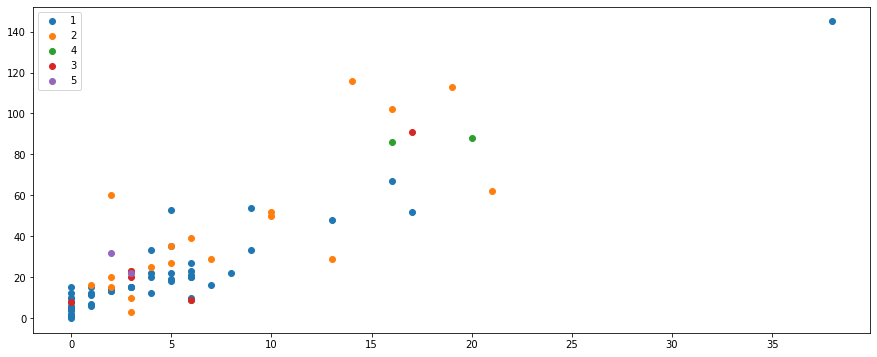

In [105]:
counter = Counter(y.values)

fig, ax = plt.subplots(figsize=(15, 6), facecolor="w")

for label, _ in counter.items():
    row_ix = where(y == label)[0]
    ax.scatter(X.values[row_ix, 0], X.values[row_ix, 1], label=str(label))
ax.legend()

### sampling_strategy='all'

In [110]:
from imblearn.over_sampling import ADASYN
print('Original dataset shape %s' % Counter(y))

ada = ADASYN(sampling_strategy='all', random_state=8, n_neighbors=1, n_jobs=1)  
X_res, y_res = ada.fit_resample(X, y)

print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({1: 46, 2: 20, 3: 5, 4: 3, 5: 2})
Resampled dataset shape Counter({2: 52, 1: 46, 5: 46, 4: 45, 3: 45})


In [114]:
print('X: ',X_res.shape, 'y: ',y_res.shape)

X:  (234, 55) y:  (234,)


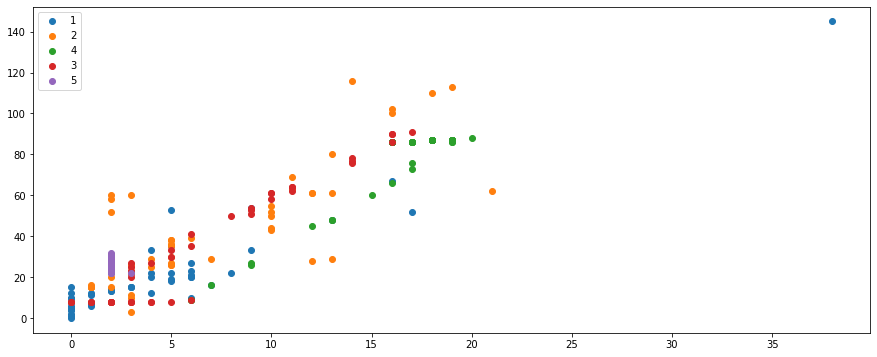

In [115]:
counter = Counter(y_res.values)

fig, ax = plt.subplots(figsize=(15, 6), facecolor="w")

for label, _ in counter.items():
    row_ix = where(y_res == label)[0]
    ax.scatter(X_res.values[row_ix, 0], X_res.values[row_ix, 1], label=str(label))
ax.legend()

> ADASYN를 이용하여 오버샘플링된 class 비율
- n_neighbors를 1로할 수 밖에 없어서 5등급(보라색)의 경우 한곳에 편향된 부분이 존재하여 학습시 과적합이 발생할 수 있을거같다.
- 설명
    * r_i = 5/5(소수클래스 주위의 k개 중 정상인것 / k개의 정상) 
    * 여기선 1등급~5등급까지 r_i가 구해지고 ri를 스케일링 한 후 G(다수클래스 - 소수클래스 개수) 를 곱해줌
    * G를 곱해주고 반올림한게 생성되는 소수 클래스 갯수
    * 소수 클래스 주변의 다수 클래스의 수에 따라 유동적으로 생성이 가능 

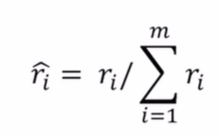

- binary케이스의 경우 Knn이 1일때 나타나는 문제!

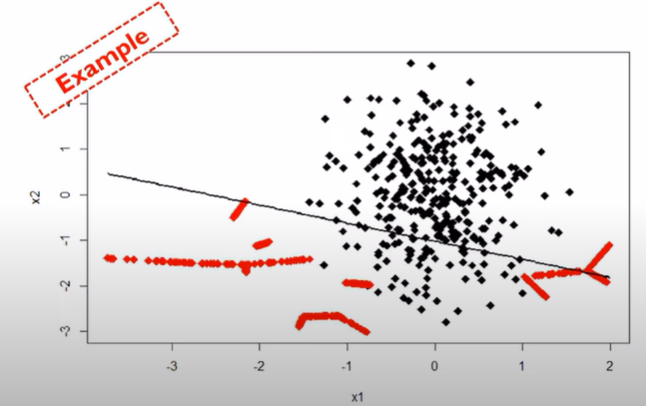

### sampling_strategy='minority'

Original dataset shape Counter({1: 46, 2: 20, 3: 5, 4: 3, 5: 2})
Resampled dataset shape Counter({1: 46, 5: 46, 2: 20, 3: 5, 4: 3})


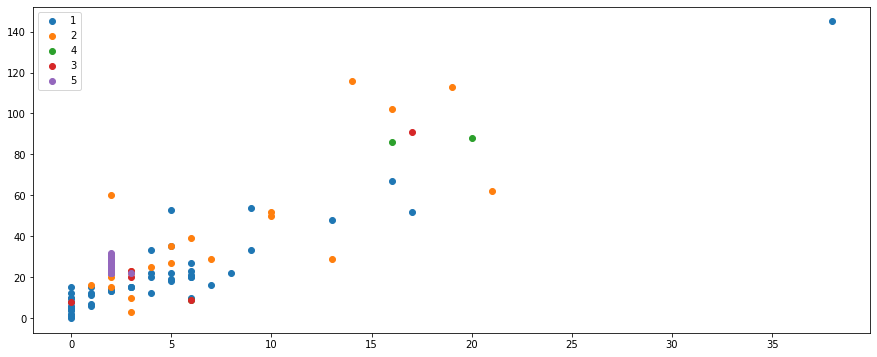

In [144]:
from imblearn.over_sampling import ADASYN
print('Original dataset shape %s' % Counter(y))

ada = ADASYN(sampling_strategy='minority', random_state=8, n_neighbors=1, n_jobs=1)  
X_res, y_res = ada.fit_resample(X, y)

print('Resampled dataset shape %s' % Counter(y_res))

counter = Counter(y_res.values)

fig, ax = plt.subplots(figsize=(15, 6), facecolor="w")

for label, _ in counter.items():
    row_ix = where(y_res == label)[0]
    ax.scatter(X_res.values[row_ix, 0], X_res.values[row_ix, 1], label=str(label))
ax.legend()

### sampling_strategy='not majority'

Original dataset shape Counter({1: 46, 2: 20, 3: 5, 4: 3, 5: 2})
Resampled dataset shape Counter({2: 52, 1: 46, 5: 46, 4: 45, 3: 45})


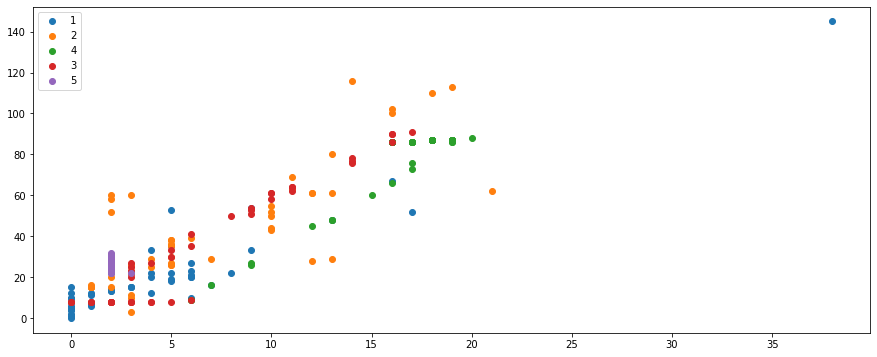

In [151]:
from imblearn.over_sampling import ADASYN
print('Original dataset shape %s' % Counter(y))

ada = ADASYN(sampling_strategy='not majority', random_state=8, n_neighbors=1, n_jobs=1)  
X_res, y_res = ada.fit_resample(X, y)

print('Resampled dataset shape %s' % Counter(y_res))

counter = Counter(y_res.values)

fig, ax = plt.subplots(figsize=(15, 6), facecolor="w")

for label, _ in counter.items():
    row_ix = where(y_res == label)[0]
    ax.scatter(X_res.values[row_ix, 0], X_res.values[row_ix, 1], label=str(label))
ax.legend()

### sampling_strategy= 'auto'
- 과반수가 아님과 동일

Original dataset shape Counter({1: 46, 2: 20, 3: 5, 4: 3, 5: 2})
Resampled dataset shape Counter({2: 52, 1: 46, 5: 46, 4: 45, 3: 45})


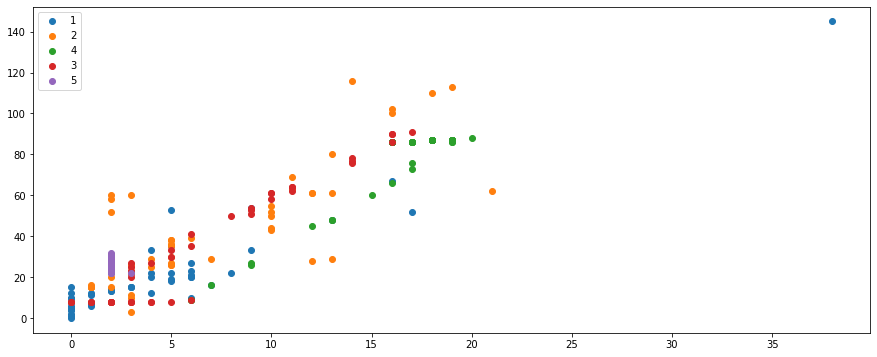

In [153]:
from imblearn.over_sampling import ADASYN
print('Original dataset shape %s' % Counter(y))

ada = ADASYN(sampling_strategy='auto', random_state=8, n_neighbors=1, n_jobs=1)  
X_res, y_res = ada.fit_resample(X, y)

print('Resampled dataset shape %s' % Counter(y_res))

counter = Counter(y_res.values)

fig, ax = plt.subplots(figsize=(15, 6), facecolor="w")

for label, _ in counter.items():
    row_ix = where(y_res == label)[0]
    ax.scatter(X_res.values[row_ix, 0], X_res.values[row_ix, 1], label=str(label))
ax.legend()

### sampling_strategy='not minority'
- 소수 클래스를 제외한 모든 클래스를 다시 샘플링

Original dataset shape Counter({1: 46, 2: 20, 3: 5, 4: 3, 5: 2})
Resampled dataset shape Counter({2: 52, 1: 46, 4: 45, 3: 45, 5: 2})


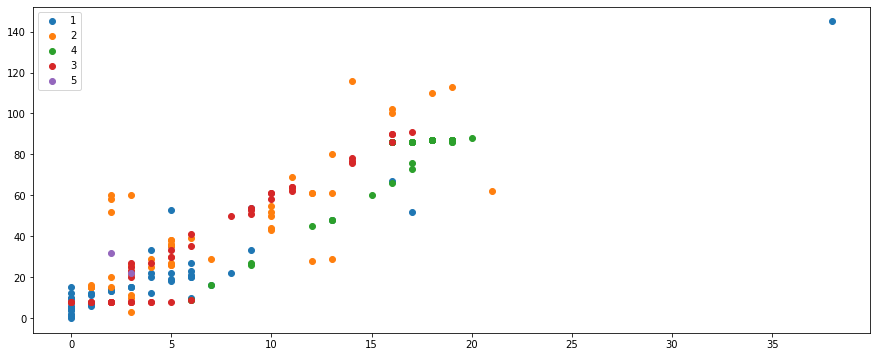

In [154]:
from imblearn.over_sampling import ADASYN
print('Original dataset shape %s' % Counter(y))

ada = ADASYN(sampling_strategy='not minority', random_state=8, n_neighbors=1, n_jobs=1)  
X_res, y_res = ada.fit_resample(X, y)

print('Resampled dataset shape %s' % Counter(y_res))

counter = Counter(y_res.values)

fig, ax = plt.subplots(figsize=(15, 6), facecolor="w")

for label, _ in counter.items():
    row_ix = where(y_res == label)[0]
    ax.scatter(X_res.values[row_ix, 0], X_res.values[row_ix, 1], label=str(label))
ax.legend()

- 오버샘플링 -> train_test_split() -> rfecv -> 학습

In [274]:
import warnings
warnings.filterwarnings('ignore')

skf = StratifiedKFold(n_splits=4)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.30, random_state=1)


model = xgb.XGBClassifier(random_state = 0, eval_metric= 'merror', objective = 'multi:softmax')
feature_selection  = RFECV(model, step = 1, cv = skf)
feature_selection  = selector.fit(X_train,y_train)
mask = np.array(feature_selection.support_)

X_train = X_train.loc[:, mask]
X_test = X_test.loc[:, mask]
X_train

print('train shape %s' % Counter(y_train))
print('test shape %s' % Counter(y_test))

train shape Counter({3: 34, 4: 34, 2: 33, 1: 31, 5: 1})
test shape Counter({2: 19, 1: 15, 3: 11, 4: 11, 5: 1})


In [275]:
unique, counts = np.unique(y_train, return_counts=True)
print("Train data set: ", dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("Test data set: ", dict(zip(unique, counts)))

baseline_model = xgb.XGBClassifier(eval_metric= 'merror', objective = 'multi:softmax',
                         random_state = 0)
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)


acc_score = accuracy_score(y_test,y_pred)
f1 = f1_score(y_test, y_pred, average = 'weighted', zero_division=1)
print("Accuracy: %.2f%%" % (acc_score * 100))
print("f1_score: %.2f%%" % (f1 * 100))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Train data set:  {1: 31, 2: 33, 3: 34, 4: 34, 5: 1}
Test data set:  {1: 15, 2: 19, 3: 11, 4: 11, 5: 1}
Accuracy: 80.70%
f1_score: 79.63%
[[ 8  7  0  0  0]
 [ 2 17  0  0  0]
 [ 0  1 10  0  0]
 [ 0  0  0 11  0]
 [ 1  0  0  0  0]]
              precision    recall  f1-score   support

           1       0.73      0.53      0.62        15
           2       0.68      0.89      0.77        19
           3       1.00      0.91      0.95        11
           4       1.00      1.00      1.00        11
           5       0.00      0.00      0.00         1

    accuracy                           0.81        57
   macro avg       0.68      0.67      0.67        57
weighted avg       0.80      0.81      0.80        57



- train_test_split() - rfecv - 오버샘플링 - 학습

Original dataset shape Counter({1: 35, 2: 15, 3: 4, 4: 2, 5: 1})
Resampled dataset shape Counter({1: 11, 2: 5, 5: 1, 4: 1, 3: 1})


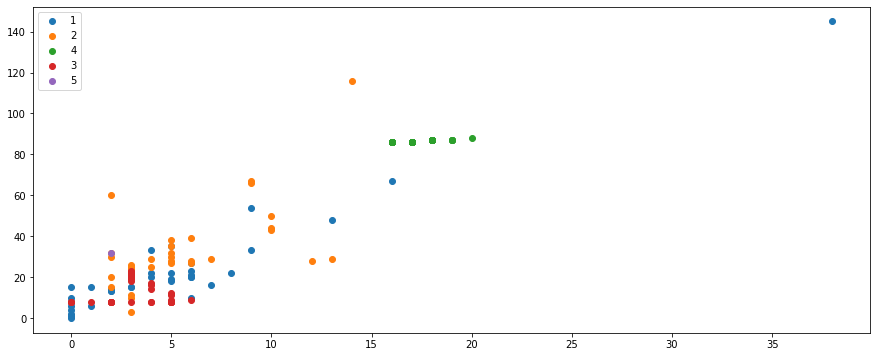

In [180]:
skf = StratifiedKFold(n_splits=4)
for train_index, test_index  in skf.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


model = xgb.XGBClassifier(random_state = 0, eval_metric= 'merror', objective = 'multi:softmax')
feature_selection  = RFECV(model, step = 1, cv = skf)
feature_selection  = selector.fit(X_train,y_train)
mask = np.array(feature_selection.support_)
X_train = X_train.loc[:, mask]
X_test = X_test.loc[:, mask]
X_train

print('Original dataset shape %s' % Counter(y_res))
ada = ADASYN(sampling_strategy='not minority', random_state=8, n_neighbors=1, n_jobs=1)  
X_res, y_res = ada.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_test))

counter = Counter(y_res.values)
fig, ax = plt.subplots(figsize=(15, 6), facecolor="w")

for label, _ in counter.items():
    row_ix = where(y_res == label)[0]
    ax.scatter(X_res.values[row_ix, 0], X_res.values[row_ix, 1], label=str(label))
ax.legend()

In [181]:
baseline_model = xgb.XGBClassifier(eval_metric= 'merror', objective = 'multi:softmax',
                         random_state = 0)
baseline_model.fit(X_res, y_res)
y_pred = baseline_model.predict(X_test)


acc_score = accuracy_score(y_test,y_pred)
f1 = f1_score(y_test, y_pred, average = 'weighted', zero_division=1)
print("Accuracy: %.2f%%" % (acc_score * 100))
print("f1_score: %.2f%%" % (f1 * 100))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Accuracy: 36.84%
f1_score: 38.60%
[[7 4 0 0 0]
 [3 0 0 2 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 1 0 0 0]]
              precision    recall  f1-score   support

           1       0.70      0.64      0.67        11
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1

    accuracy                           0.37        19
   macro avg       0.14      0.13      0.13        19
weighted avg       0.41      0.37      0.39        19



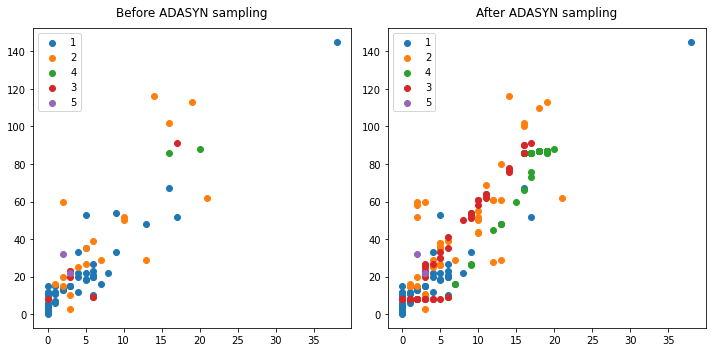

In [277]:
counter_y = Counter(y.values)
counter_y_res = Counter(y_res.values)

fig, axs = plt.subplots(ncols=2, figsize=(10,5))

for label, _ in counter_y.items():
    row_ix = where(y == label)[0]
    axs[0].scatter(X.values[row_ix, 0], X.values[row_ix, 1], label=str(label))
axs[0].legend()

for label, _ in counter.items():
    row_ix = where(y_res == label)[0]
    axs[1].scatter(X_res.values[row_ix, 0], X_res.values[row_ix, 1], label=str(label))
axs[1].legend()

axs[0].set_title("Before ADASYN sampling", pad=12)
axs[1].set_title("After ADASYN sampling", pad=12)

fig.tight_layout()

# reference
- https://www.kaggle.com/dktalaicha/credit-card-fraud-detection-using-smote-adasyn
- https://www.kaggle.com/anirudhg15/heart-failure-prediction-adasyn-xgboost-85-f1
- https://www.datasciencecentral.com/profiles/blogs/handling-imbalanced-data-sets-in-supervised-learning-using-family\
- https://datascienceschool.net/03%20machine%20learning/14.02%20%EB%B9%84%EB%8C%80%EC%B9%AD%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EB%AC%B8%EC%A0%9C.html